# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from dyn_cond_fig_functions import *

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

In [3]:
cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec

# Figure 4

## Snapshots of the simulation

In [4]:
!pvpython /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/pv_snapshot_chromatin.py /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-05_aLc1_line1600_Pin5um_Ke30_ks100_2patch_100sep/

!cp /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-05_aLc1_line1600_Pin5um_Ke30_ks100_2patch_100sep/snapshot_chromatin_last.png Figure4/two_patch_snapshot.png

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Final snapshot of the baseline simulation at 3um separation and Ke=100.

<img width="50%" src="Figure4/two_patch_snapshot.png?raw=true"></img>


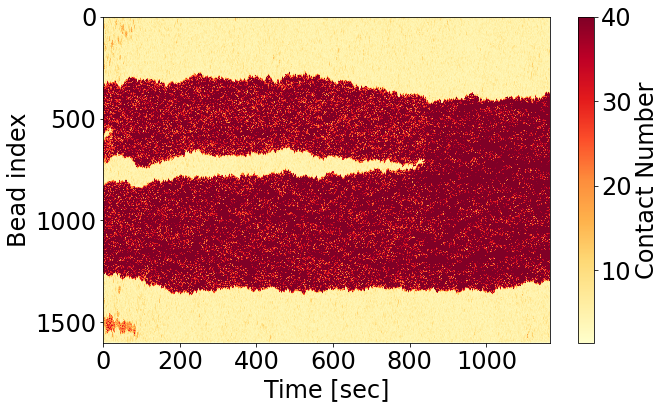

In [10]:
h5_contact_file = ceph_path / "DynCondPaper/24-03-07_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil/simulations/s7/analysis/contact_analysis.h5"

fig, axarr = plt.subplots(1,1, figsize=(10, 6))
_ = axarr.set_ylim(0, 1600)

with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]
    
    cgf.plot_contact_kymo(fig, axarr, time_arr, contact_kymo, vmax=vmax)
    axarr.invert_yaxis()



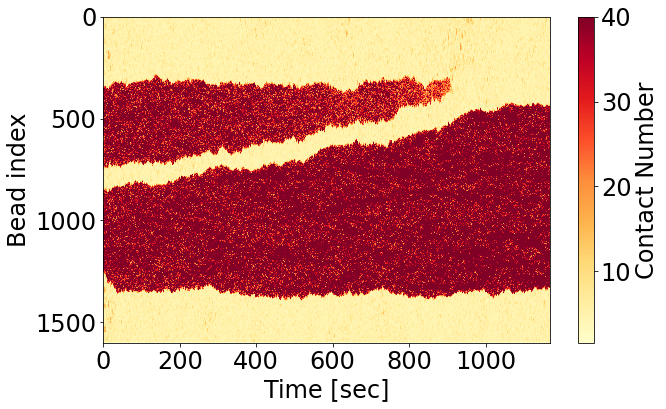

In [82]:
h5_contact_file = ceph_path / "DynCondPaper/24-03-07_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil/simulations/s10/analysis/contact_analysis.h5"

fig, axarr = plt.subplots(1,1, figsize=(10, 6))
_ = axarr.set_ylim(0, 1600)

with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]
    
    cgf.plot_contact_kymo(fig, axarr, time_arr, contact_kymo, vmax=vmax)
    axarr.invert_yaxis()



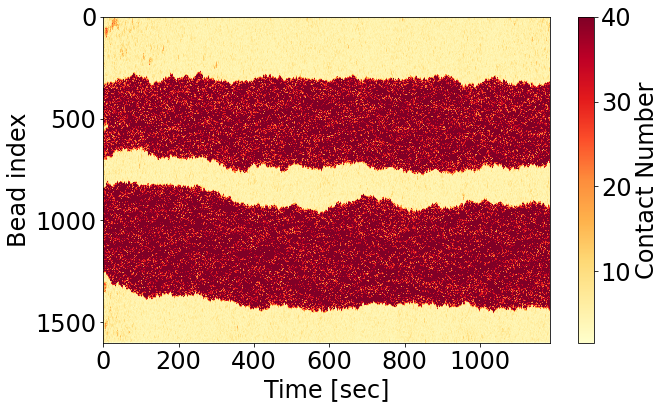

In [87]:
h5_contact_file = ceph_path / "DynCondPaper/24-03-07_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil/simulations/s15/analysis/contact_analysis.h5"

fig, axarr = plt.subplots(1,1, figsize=(10, 6))
_ = axarr.set_ylim(0, 1600)

with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]
    
    cgf.plot_contact_kymo(fig, axarr, time_arr, contact_kymo, vmax=vmax)
    axarr.invert_yaxis()



In [4]:
data_path = ceph_path / "DynCondPaper/24-03-07_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

print(len(h5_list))

large_tree_length = 240

merge_life_times = []
dissolve_life_times = [] 
merge_time_arr = []
dissolve_time_arr = []
merge_cluster_arr = []
dissolve_cluster_arr = []
nothing_events = 0
nothing_time_arr = []
nothing_cluster_arr = []

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

graph_side_length = int(np.ceil(np.sqrt(len(h5_list))))
# graph_side_length = 3

# fig, axarr = plt.subplots(graph_side_length, graph_side_length, figsize=(32, 24))

n = 0
for i in range(graph_side_length):
    for j in range(graph_side_length):
        n += 1
        if i*graph_side_length + j >= len(h5_list):
            print('break')
            break
        try: 
            with h5py.File(h5_list[i*graph_side_length+j], 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                last_time = time_arr[-1]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            # The largest clusters at the start of the sim
            start_clusters = sorted(clusters[0], key=lambda x: len(x.part_ids), reverse=True)

            root0 = start_clusters[0].get_root()
            root1 = start_clusters[1].get_root()

            # If the two largest beginning clusters have the same root id at the end,
            # then this is a merging event

            if root0.id == root1.id:
                # Make the tree for these
                merge_tree = cla.ClusterTree(0) 
                merge_tree.add_recursive(root0)
                # Branch root with the largest mass history
                branch_root = sorted(merge_tree.get_branch_roots(), key=lambda x: x.mass_hist, reverse=True)[1]
                merge_life_times += [branch_root.time]
                print(f"{n} Merge event at time {branch_root.time}")

                l_branch = root0.get_largest_branch()
                size_arr = np.zeros(len(l_branch))
                time_arr = np.zeros(len(l_branch))
                for k, clust in enumerate(l_branch):
                    size_arr[k] = len(clust.part_ids)
                    time_arr[k] = clust.time
                merge_time_arr += [time_arr.copy()]
                merge_cluster_arr += [size_arr.copy()]

                sl_branch = branch_root.get_largest_branch()
                size_arr = np.zeros(len(sl_branch))
                time_arr = np.zeros(len(sl_branch))
                for k, clust in enumerate(sl_branch):
                    size_arr[k] = len(clust.part_ids)
                    time_arr[k] = clust.time
                merge_time_arr += [time_arr.copy()]
                merge_cluster_arr += [size_arr.copy()]

                continue

            min_root_time = min(root0.time, root1.time)
            if min_root_time < last_time:
                dissolve_life_times += [min_root_time]
                print(f"{n} Dissolve event at time {min_root_time}")

                l_branch = root0.get_all_progenitors()
                size_arr = np.zeros(len(l_branch))
                time_arr = np.zeros(len(l_branch))
                for k, clust in enumerate(l_branch):
                    size_arr[k] = len(clust.part_ids)
                    time_arr[k] = clust.time
                dissolve_time_arr += [time_arr.copy()]
                dissolve_cluster_arr += [size_arr.copy()]

                l_branch = root1.get_all_progenitors()
                size_arr = np.zeros(len(l_branch))
                time_arr = np.zeros(len(l_branch))
                for k, clust in enumerate(l_branch):
                    size_arr[k] = len(clust.part_ids)
                    time_arr[k] = clust.time

                dissolve_time_arr += [time_arr.copy()]
                dissolve_cluster_arr += [size_arr.copy()]
                

                continue
            
            nothing_events += 1
            print(f"{n} Nothing event")

            l_branch = root0.get_all_progenitors()
            size_arr = np.zeros(len(l_branch))
            time_arr = np.zeros(len(l_branch))
            for k, clust in enumerate(l_branch):
                size_arr[k] = len(clust.part_ids)
                time_arr[k] = clust.time
            nothing_time_arr += [time_arr.copy()]
            nothing_cluster_arr += [size_arr.copy()]

            l_branch = root1.get_all_progenitors()
            size_arr = np.zeros(len(l_branch))
            time_arr = np.zeros(len(l_branch))
            for k, clust in enumerate(l_branch):
                # if len(clust.part_ids) < 10:

                size_arr[k] = len(clust.part_ids)
                time_arr[k] = clust.time

            nothing_time_arr += [time_arr.copy()]
            nothing_cluster_arr += [size_arr.copy()]

        except:
            raise

48
1 Merge event at time 733.5
2 Dissolve event at time 1010.0
3 Merge event at time 577.0
4 Nothing event
5 Nothing event
6 Dissolve event at time 577.5
7 Nothing event
8 Dissolve event at time 876.5
9 Dissolve event at time 818.5
10 Dissolve event at time 1071.5
11 Nothing event
12 Dissolve event at time 713.5
13 Nothing event
14 Merge event at time 597.0
15 Nothing event
16 Nothing event
17 Nothing event
18 Dissolve event at time 396.0
19 Nothing event
20 Dissolve event at time 606.0
21 Dissolve event at time 885.5
22 Merge event at time 840.5
23 Merge event at time 799.5
24 Nothing event
25 Nothing event
26 Nothing event
27 Dissolve event at time 644.5
28 Nothing event
29 Dissolve event at time 914.0
30 Merge event at time 373.5
31 Nothing event
32 Nothing event
33 Nothing event
34 Dissolve event at time 1122.5
35 Nothing event
36 Merge event at time 1174.0
37 Nothing event
38 Merge event at time 1144.0
39 Dissolve event at time 572.0
40 Nothing event
41 Merge event at time 572.5
4

NameError: name 'fig' is not defined

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


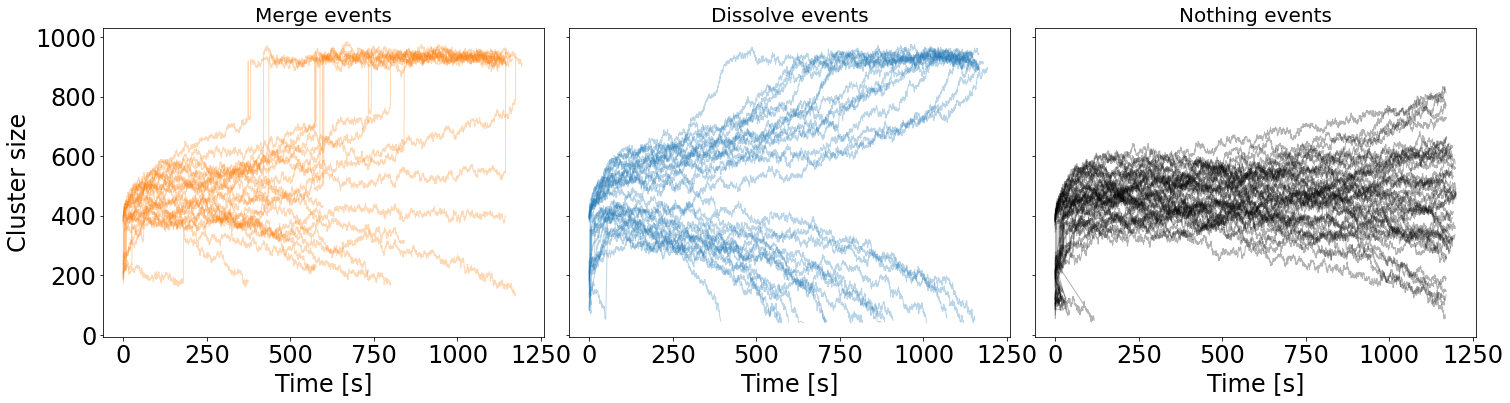

In [5]:
fig, axarr = plt.subplots(1,3, figsize=(21,6), sharey=True, sharex=True)
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

for time_arr, clust_arr, in zip(merge_time_arr, merge_cluster_arr):
    _ = axarr[0].plot(time_arr, clust_arr, color='tab:orange', **plot_params)   

for time_arr, clust_arr, in zip(dissolve_time_arr, dissolve_cluster_arr):
    condition = clust_arr > 40 
    
    _ = axarr[1].plot(time_arr[condition], clust_arr[condition], color='tab:blue', **plot_params)

for time_arr, clust_arr, in zip(nothing_time_arr, nothing_cluster_arr):
    condition = clust_arr > 40
    
    _ = axarr[2].plot(time_arr[condition], clust_arr[condition], color='black', **plot_params)

_ = axarr[0].set_title('Merge events')
_ = axarr[1].set_title('Dissolve events')
_ = axarr[2].set_title('Nothing events')

_ = axarr[0].set_ylabel('Cluster size')
for ax in axarr:
    _ = ax.set_xlabel('Time [s]')


fig.tight_layout()

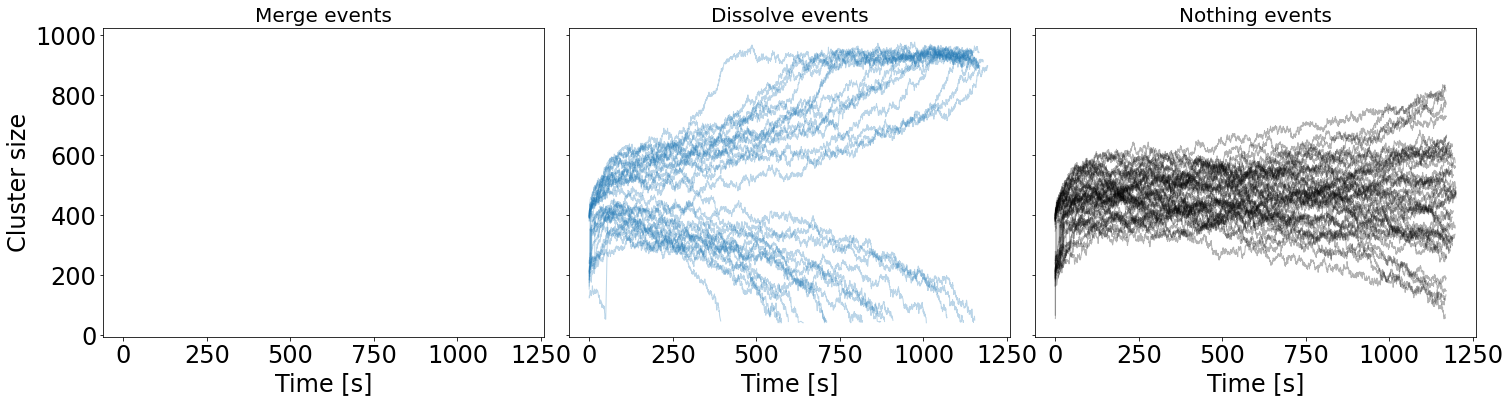

In [17]:
fig, axarr = plt.subplots(1,3, figsize=(21,6), sharey=True, sharex=True)
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

# for time_arr, clust_arr, in zip(merge_time_arr, merge_cluster_arr):
#     _ = axarr[0].plot(time_arr, clust_arr, color='tab:orange', **plot_params)   

dissolve_clust_large_list = []
dissolve_clust_small_list = []

for time_arr, clust_arr, in zip(dissolve_time_arr, dissolve_cluster_arr):
    condition = clust_arr > 40 
    # condition = clust_arr > 1 

    filter_time = time_arr[condition][::-1] # The arrays are currently in reverse order
    filter_cluster = clust_arr[condition][::-1]
    split_ind = np.where(np.diff(filter_time) < 0)[0] + 1
    split_time_arr = np.split(filter_time, split_ind)
    split_clust_arr = np.split(filter_cluster, split_ind)

    plot_time_arr = max(split_time_arr, key=lambda x: len(x))
    plot_clust_arr = max(split_clust_arr, key=lambda x: len(x))
    if plot_clust_arr[-1] > 400:
        dissolve_clust_large_list += [(plot_time_arr, plot_clust_arr)]
    else:
        dissolve_clust_small_list += [(plot_time_arr, plot_clust_arr)]
    
    
    _ = axarr[1].plot(plot_time_arr, plot_clust_arr, color='tab:blue', **plot_params)

for time_arr, clust_arr, in zip(nothing_time_arr, nothing_cluster_arr):
    condition = clust_arr > 40 

    filter_time = time_arr[condition][::-1] # The arrays are currently in reverse order
    filter_cluster = clust_arr[condition][::-1]
    split_ind = np.where(np.diff(filter_time) < 0)[0] + 1
    split_time_arr = np.split(filter_time, split_ind)
    split_clust_arr = np.split(filter_cluster, split_ind)

    plot_time_arr = max(split_time_arr, key=lambda x: len(x))
    plot_clust_arr = max(split_clust_arr, key=lambda x: len(x))
    
    
    _ = axarr[2].plot(plot_time_arr, plot_clust_arr, color='black', **plot_params)

_ = axarr[0].set_title('Merge events')
_ = axarr[1].set_title('Dissolve events')
_ = axarr[2].set_title('Nothing events')

_ = axarr[0].set_ylabel('Cluster size')
for ax in axarr:
    _ = ax.set_xlabel('Time [s]')


fig.tight_layout()

<BarContainer object of 3 artists>

Text(0, 0.5, 'Number of events')

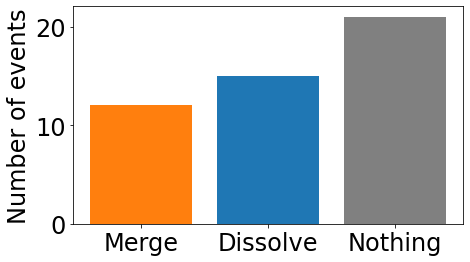

In [67]:
# Bar graph of merge events vs dissolve events vs nothing events
fig, ax = plt.subplots(1,1, figsize=(7, 4))
ax.bar(['Merge', 'Dissolve', 'Nothing'], [len(merge_life_times), len(dissolve_life_times), nothing_events], color=['tab:orange', 'tab:blue', 'grey'])
ax.set_ylabel('Number of events')

(array([0., 0., 0., 0., 0., 0., 2., 1., 0., 4., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 2.]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200.]),
 <BarContainer object of 20 artists>)

(array([0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 2., 2., 0., 1., 2., 1., 1.,
        1., 1., 1.]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200.]),
 <BarContainer object of 20 artists>)

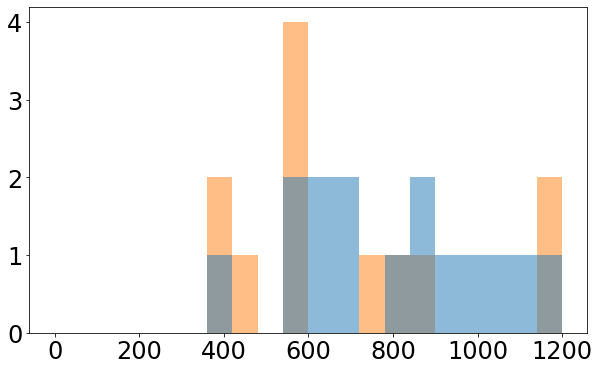

In [91]:
# Histogram of all events
fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.hist(merge_life_times, bins=20, color='tab:orange', alpha=.5, label='Merge', range=(0, 1200))
ax.hist(dissolve_life_times, bins=20, color='tab:blue', alpha=.5, label='Dissolve',range=(0, 1200))

# Supplemental figures

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


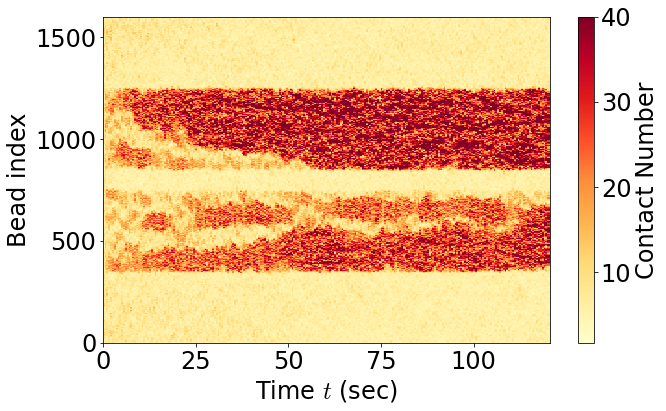

In [5]:
h5_contact_file = ceph_path / "DynCondPaper/24-03-05_aLc1_line1600_Pin5um_Ke30_ks100_2patch_100sep/analysis/contact_analysis.h5"

fig, axarr = plt.subplots(1,1, figsize=(10, 6))
_ = axarr.set_ylim(0, 1600)

with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]
    
    cgf.plot_contact_kymo(fig, axarr, time_arr, contact_kymo, vmax=vmax)



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


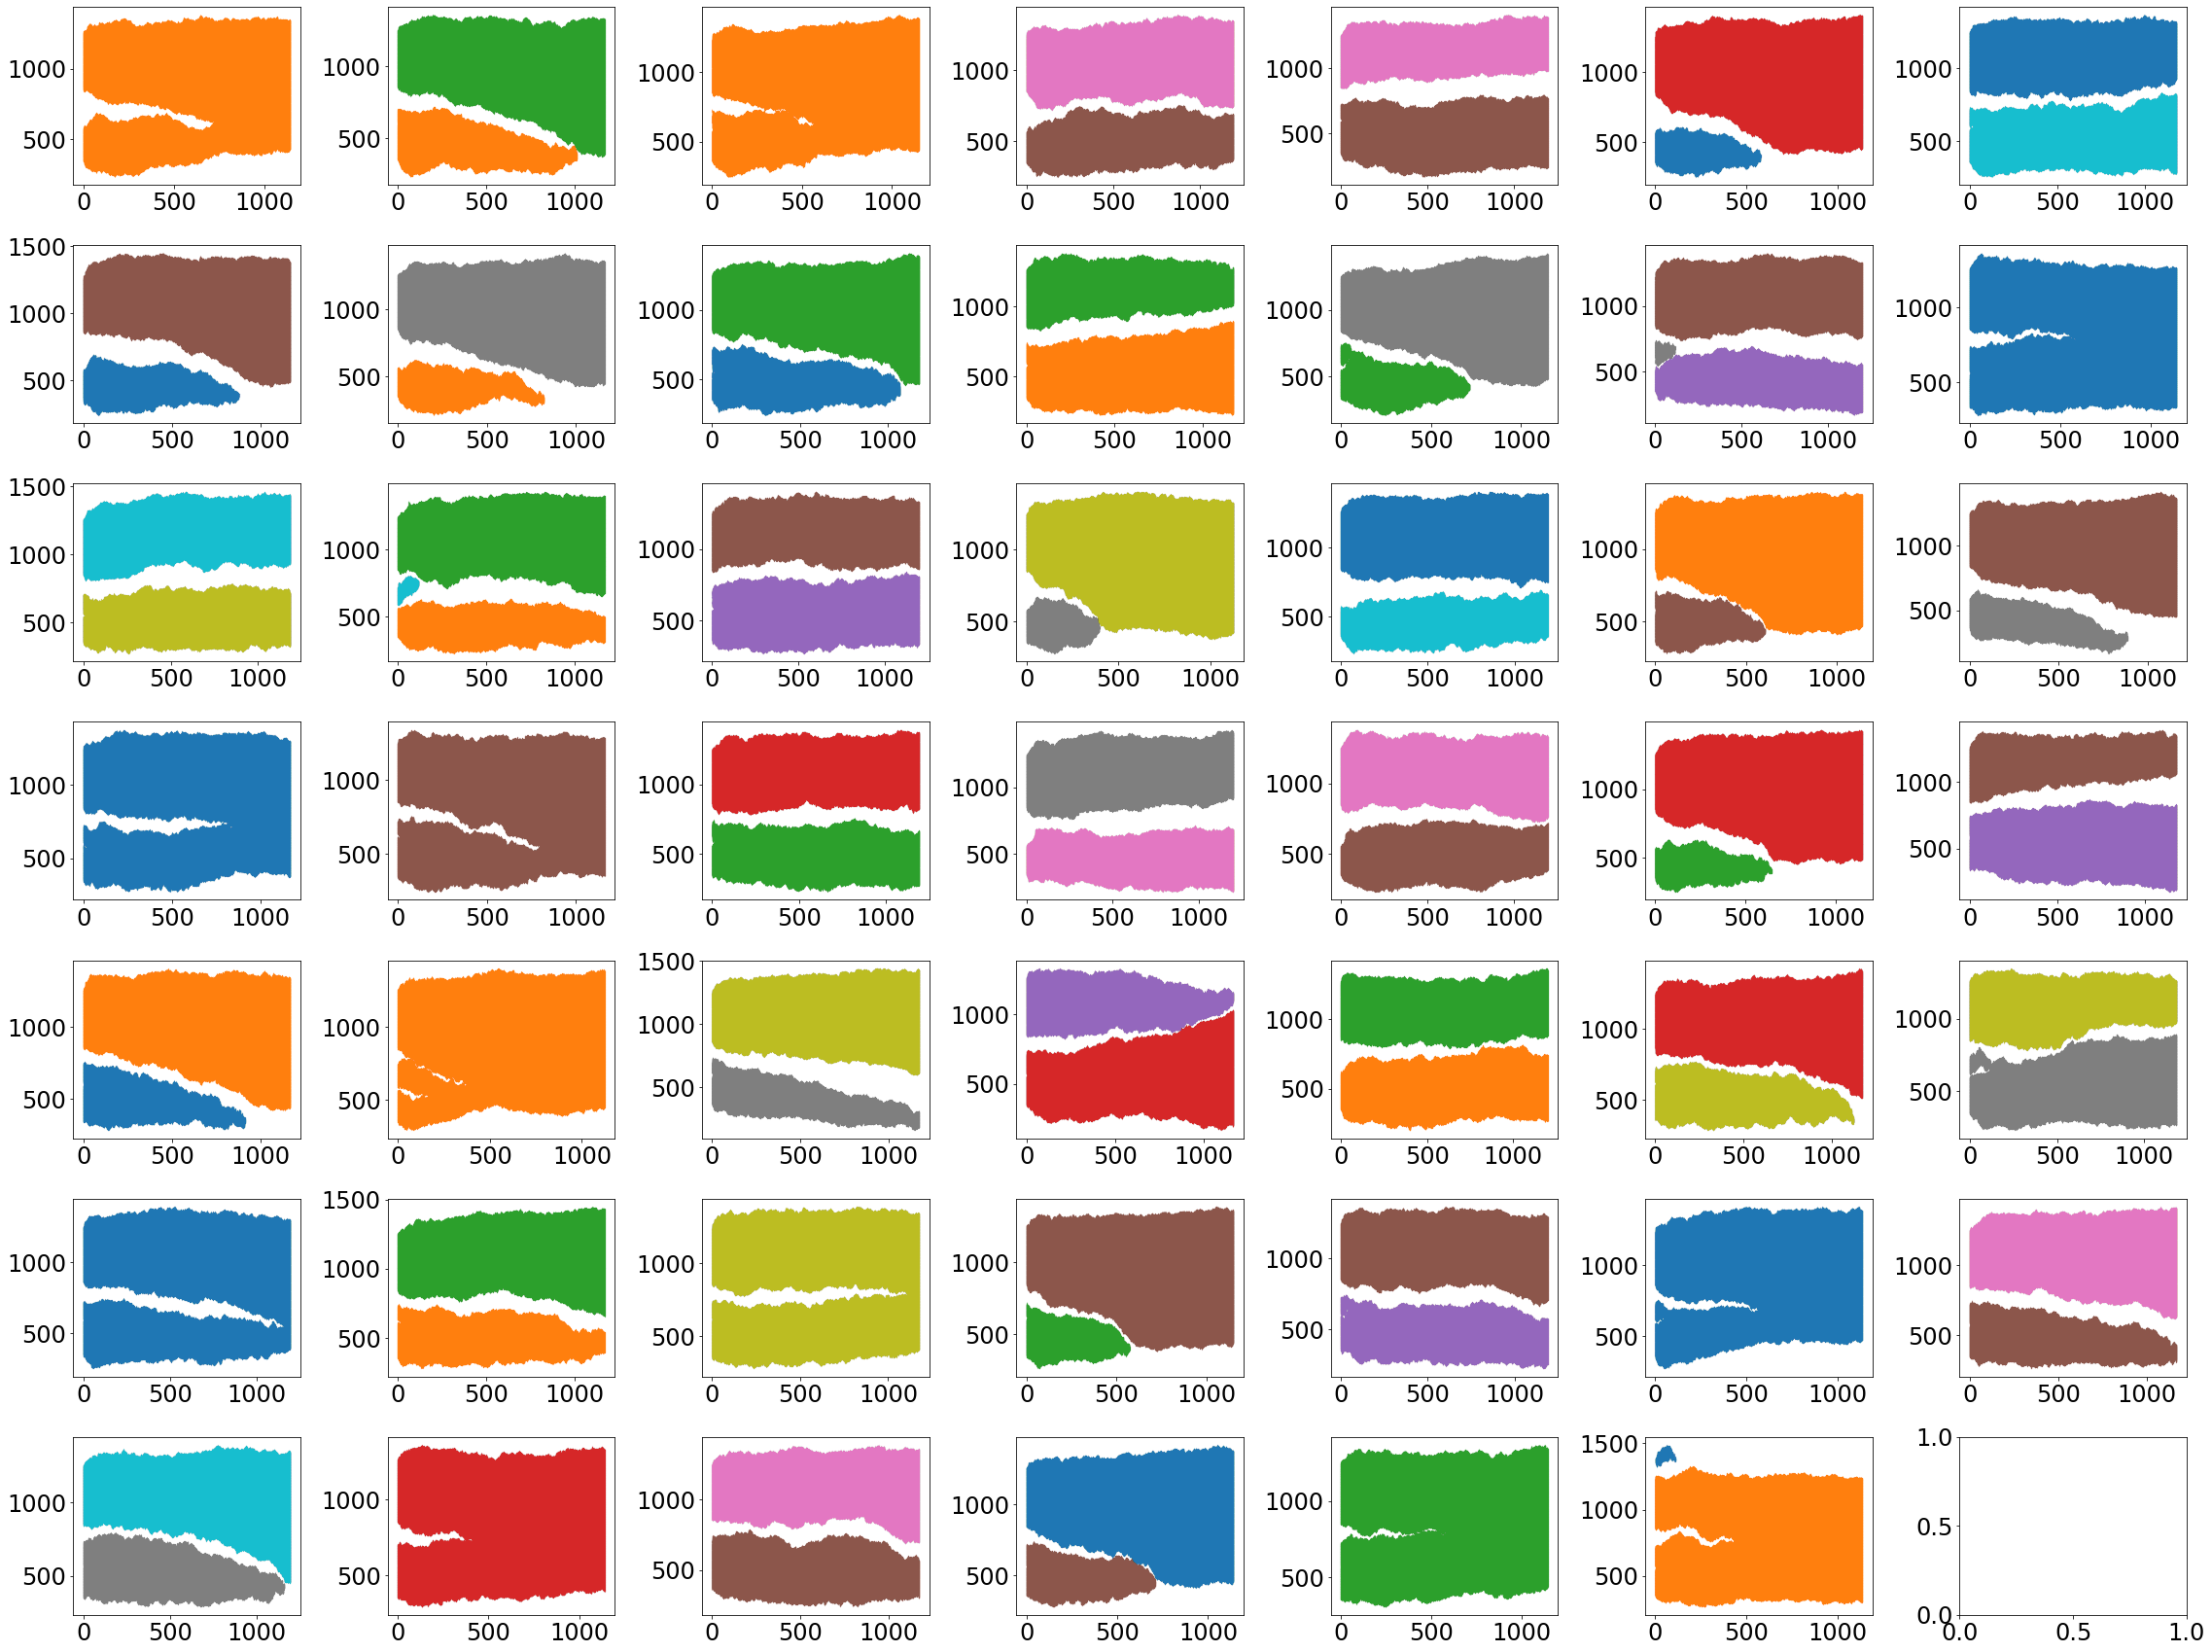

In [ ]:
data_path = ceph_path / "DynCondPaper/24-03-07_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

large_tree_length = 200

merge_events = 0
dissovle_events = 0
nothing_events = 0

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

graph_side_length = int(np.ceil(np.sqrt(len(h5_list))))

fig, axarr = plt.subplots(graph_side_length, graph_side_length, figsize=(32, 24))
for i in range(graph_side_length):
    for j in range(graph_side_length):
        if i*graph_side_length + j >= len(h5_list):
            break
        try: 
            with h5py.File(h5_list[i*graph_side_length+j], 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            trees = []
            tree_id_gen = aa.helpers.gen_id()
            for root in root_clusters:
                tree = cla.ClusterTree(next(tree_id_gen))
                tree.add_recursive(root)
                trees += [tree]


            # Graph all clusters
            for tree, color in zip(trees, tableau10_colors):
                if len(tree.clusters) < large_tree_length:
                    continue
                for clust in tree.clusters:
                    _ = axarr[i,j].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')
        except:
            raise

fig.tight_layout()


